The initial data retrieval (wiki_german_de) is done via Wikidata API then enriched with the data from the Wikipedia. The data is then translated (where applicable), cleaned and preprocessed to be used for the model training.

In [ ]:
# Packages
import pandas as pd
from nltk.corpus import stopwords
import nltk
import geopandas as gpd
import seaborn as sns


In [111]:
# Loading the dataset that has the initial retrieved Wikidata (wiki_german_de.py)
wiki = pd.read_csv('final_combined_results.csv')
print(len(wiki))
# Sort by person and prioritize rows with more non-null values
wiki['non_null_count'] = wiki.notnull().sum(axis=1)  # Count non-null values in each row
wiki = wiki.sort_values(by=['person', 'non_null_count'], ascending=[True, False])
wiki = wiki.drop_duplicates(subset='person', keep='first').drop(columns=['non_null_count'])


216609


In [112]:
# Loading the dataset that has all the retrieved geodata (wiki_birth)
birth = pd.read_csv('final_birth_results.csv')

# Sort by birthdate and prioritize rows with more non-null values
birth['non_null_count'] = birth.notnull().sum(axis=1)  # Count non-null values in each row
birth = birth.sort_values(by=['person', 'non_null_count', 'birthdate'], ascending=[True, False, True])
birth = birth.drop_duplicates(subset='person', keep='first').drop(columns=['non_null_count'])


In [113]:
birth.isnull().sum()

person                        0
birthplace                    0
birthdate                     0
personLabel                   0
birthplaceCoordinates       422
placeOfDeath             113330
dtype: int64

In [114]:
wiki.isnull().sum()

person              0
birthdate           0
genderLabel         0
birthYear           0
personLabel         0
GermanWikipedia     0
EnglishWikipedia    0
dtype: int64

In [115]:
# Merging the two datasets, retaining all persons from wiki
df = pd.merge(wiki, birth[['person', 'birthplace', 'birthplaceCoordinates', 'placeOfDeath']], on='person', how='left')
df

,person,birthdate,genderLabel,birthYear,personLabel,GermanWikipedia,EnglishWikipedia,birthplace,birthplaceCoordinates,placeOfDeath
0,http://www.wikidata.org/entity/Q1000002,1932-12-04T00:00:00Z,männlich,1932,Claus Hammel,https://de.wikipedia.org/wiki/Claus_Hammel,No,http://www.wikidata.org/entity/Q559010,Point(11.848212396 53.4277155),http://www.wikidata.org/entity/Q402819
1,http://www.wikidata.org/entity/Q1000006,1971-07-14T00:00:00Z,männlich,1971,Florian Eichinger,https://de.wikipedia.org/wiki/Florian_Eichinger,No,http://www.wikidata.org/entity/Q622,Point(9.191944444 48.8975),NaN
2,http://www.wikidata.org/entity/Q1000015,1983-06-23T00:00:00Z,männlich,1983,Florian Jahr,https://de.wikipedia.org/wiki/Florian_Jahr,No,http://www.wikidata.org/entity/Q64,Point(13.383333333 52.516666666),NaN
3,http://www.wikidata.org/entity/Q1000023,1912-08-07T00:00:00Z,weiblich,1912,Wiltraut Rupp-von Brünneck,https://de.wikipedia.org/wiki/Wiltraut_Rupp-vo...,No,http://www.wikidata.org/entity/Q671474,Point(13.35 52.4333),http://www.wikidata.org/entity/Q1040
4,http://www.wikidata.org/entity/Q1000045,1915-04-03T00:00:00Z,männlich,1915,Eugen Brammertz,https://de.wikipedia.org/wiki/Eugen_Brammertz,No,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
216604,http://www.wikidata.org/entity/Q999889,1958-01-01T00:00:00Z,männlich,1958,Robert Rauch,https://de.wikipedia.org/wiki/Robert_Rauch,No,http://www.wikidata.org/entity/Q572921,Point(10.433333333 48.566666666),NaN
216605,http://www.wikidata.org/entity/Q999901,1943-07-07T00:00:00Z,weiblich,1943,Heidemarie Rohweder,https://de.wikipedia.org/wiki/Heidemarie_Rohweder,No,http://www.wikidata.org/entity/Q149861,Point(8.998838888 54.125327777),http://www.wikidata.org/entity/Q64
216606,http://www.wikidata.org/entity/Q999935,1911-01-01T00:00:00Z,männlich,1911,Rudi Wendel,https://de.wikipedia.org/wiki/Rudi_Wendel,No,http://www.wikidata.org/entity/Q1478877,Point(8.308411111 50.722383333),NaN
216607,http://www.wikidata.org/entity/Q999970,1932-01-01T00:00:00Z,männlich,1932,Hartmut Wortmann,https://de.wikipedia.org/wiki/Hartmut_Wortmann,No,http://www.wikidata.org/entity/Q152356,Point(6.66667 50.25),NaN


In [116]:
#Check missing values per column

df.isnull().sum()


person                        0
birthdate                     0
genderLabel                   0
birthYear                     0
personLabel                   0
GermanWikipedia               0
EnglishWikipedia              0
birthplace                22421
birthplaceCoordinates     22843
placeOfDeath             135728
dtype: int64

In [117]:
#The rows with missing values - getting the person ID and saving it to a list
missing = df[df.isnull().any(axis=1)]
missing = missing['person'].tolist()
print(len(missing))

#Save as csv file with column wikidata_id

missing_df = pd.DataFrame(missing, columns=['wikidata_id'])
missing_df.to_csv('missing_persons.csv', index=False)

missing_df

135958


,wikidata_id
0,http://www.wikidata.org/entity/Q1000006
1,http://www.wikidata.org/entity/Q1000015
2,http://www.wikidata.org/entity/Q1000045
3,http://www.wikidata.org/entity/Q1000050
4,http://www.wikidata.org/entity/Q1000074
...,...
135953,http://www.wikidata.org/entity/Q99982363
135954,http://www.wikidata.org/entity/Q999889
135955,http://www.wikidata.org/entity/Q999935
135956,http://www.wikidata.org/entity/Q999970


In [118]:
# Loading the missing persons dataset where the data was retrieved from the API (missing.py)
missing = pd.read_csv('combined_missing_results.csv')

# Sorting the missing DataFrame by the 'birthdate' column
missing = missing.sort_values('birthdate').dropna(subset=['person']).drop_duplicates(subset=['person'])
missing.isnull().sum()


person                        0
birthdate                     0
birthplace                    0
personLabel                   0
birthplaceCoordinates       431
placeOfDeath             113327
wikidata_id              113583
dtype: int64

Getting a merged dataset with the missing data

In [119]:
# Merge df with missing on 'person', prioritizing data from df
final = pd.merge(df, missing, on='person', how='left', suffixes=('_df', '_missing'))

# Fill missing values in df columns with data from missing
final['birthplace'] = final['birthplace_df'].combine_first(final['birthplace_missing'])
final['birthplaceCoordinates'] = final['birthplaceCoordinates_df'].combine_first(final['birthplaceCoordinates_missing'])
final['placeOfDeath'] = final['placeOfDeath_df'].combine_first(final['placeOfDeath_missing'])

# Drop unnecessary columns from the merge
final = final.drop(columns=[
    'birthplace_df', 'birthplace_missing',
    'birthplaceCoordinates_df', 'birthplaceCoordinates_missing',
    'placeOfDeath_df', 'placeOfDeath_missing', 'birthdate_missing', 'personLabel_missing', 'wikidata_id'
])

# Ensure no duplicates exist
final = final.drop_duplicates(subset=['person'])

# Check for missing values
missing_values = final.isnull().sum()
print("Missing values per column:")
print(missing_values)
final.head()

Missing values per column:
person                        0
birthdate_df                  0
genderLabel                   0
birthYear                     0
personLabel_df                0
GermanWikipedia               0
EnglishWikipedia              0
birthplace                22387
birthplaceCoordinates     22809
placeOfDeath             135714
dtype: int64


,person,birthdate_df,genderLabel,birthYear,personLabel_df,GermanWikipedia,EnglishWikipedia,birthplace,birthplaceCoordinates,placeOfDeath
0,http://www.wikidata.org/entity/Q1000002,1932-12-04T00:00:00Z,männlich,1932,Claus Hammel,https://de.wikipedia.org/wiki/Claus_Hammel,No,http://www.wikidata.org/entity/Q559010,Point(11.848212396 53.4277155),http://www.wikidata.org/entity/Q402819
1,http://www.wikidata.org/entity/Q1000006,1971-07-14T00:00:00Z,männlich,1971,Florian Eichinger,https://de.wikipedia.org/wiki/Florian_Eichinger,No,http://www.wikidata.org/entity/Q622,Point(9.191944444 48.8975),NaN
2,http://www.wikidata.org/entity/Q1000015,1983-06-23T00:00:00Z,männlich,1983,Florian Jahr,https://de.wikipedia.org/wiki/Florian_Jahr,No,http://www.wikidata.org/entity/Q64,Point(13.383333333 52.516666666),NaN
3,http://www.wikidata.org/entity/Q1000023,1912-08-07T00:00:00Z,weiblich,1912,Wiltraut Rupp-von Brünneck,https://de.wikipedia.org/wiki/Wiltraut_Rupp-vo...,No,http://www.wikidata.org/entity/Q671474,Point(13.35 52.4333),http://www.wikidata.org/entity/Q1040
4,http://www.wikidata.org/entity/Q1000045,1915-04-03T00:00:00Z,männlich,1915,Eugen Brammertz,https://de.wikipedia.org/wiki/Eugen_Brammertz,No,NaN,NaN,NaN


In [120]:
# Save the final csv 

final.to_csv('final_dataset.csv', index=False)

The current birthplaces are saved as Wikidata IDs and therefore needed additional processing to get the actual birthplaces

In [121]:
# Loading the final data with labels (birth;label.py)
data_birthlabel = pd.read_csv('final_dataset_with_labels.csv')
data_birthlabel.sort_values('birthdate_df')

,person,birthdate_df,genderLabel,birthYear,personLabel_df,GermanWikipedia,EnglishWikipedia,birthplace,birthplaceCoordinates,placeOfDeath,birthplace_id,label
50958,http://www.wikidata.org/entity/Q1459579,1525-01-01T00:00:00Z,männlich,1525,Wolfgang Figulus,https://de.wikipedia.org/wiki/Wolfgang_Figulus,https://en.wikipedia.org/wiki/Wolfgang_Figulus,http://www.wikidata.org/entity/Q15986,Point(11.809819 51.152095),http://www.wikidata.org/entity/Q8738,Q15986,Naumburg
193744,http://www.wikidata.org/entity/Q70830,1525-01-01T00:00:00Z,männlich,1525,Friedrich Dedekind,https://de.wikipedia.org/wiki/Friedrich_Dedekind,https://en.wikipedia.org/wiki/Friedrich_Dedekind,http://www.wikidata.org/entity/Q7014,Point(9.46358 52.5055),http://www.wikidata.org/entity/Q3920,Q7014,Neustadt am Rübenberge
100696,http://www.wikidata.org/entity/Q1697469,1525-01-01T00:00:00Z,männlich,1525,Johannes Ewich,https://de.wikipedia.org/wiki/Johannes_Ewich,No,http://www.wikidata.org/entity/Q1622841,Point(6.47 51.5103),http://www.wikidata.org/entity/Q24879,Q1622841,Hoerstgen
1644,http://www.wikidata.org/entity/Q101994,1525-01-01T00:00:00Z,männlich,1525,Hans Wilhelm Kirchhof,https://de.wikipedia.org/wiki/Hans_Wilhelm_Kir...,https://en.wikipedia.org/wiki/Hans_Wilhelm_Kir...,http://www.wikidata.org/entity/Q2865,Point(9.497916666 51.315777777),http://www.wikidata.org/entity/Q628667,Q2865,Kassel
213160,http://www.wikidata.org/entity/Q97557,1525-01-01T00:00:00Z,männlich,1525,Heinrich Compenius der Ältere,https://de.wikipedia.org/wiki/Heinrich_Compeni...,No,http://www.wikidata.org/entity/Q3963,Point(9.6775 50.552777777),http://www.wikidata.org/entity/Q7033,Q3963,Fulda
...,...,...,...,...,...,...,...,...,...,...,...,...
208381,http://www.wikidata.org/entity/Q91806687,2010-01-01T00:00:00Z,männlich,2010,Julius Göze,https://de.wikipedia.org/wiki/Julius_G%C3%B6ze,No,http://www.wikidata.org/entity/Q64,Point(13.383333333 52.516666666),NaN,Q64,Berlin
35282,http://www.wikidata.org/entity/Q132577539,2010-06-06T00:00:00Z,weiblich,2010,Zah1de,https://de.wikipedia.org/wiki/Zah1de,No,NaN,NaN,NaN,NaN,NaN
24345,http://www.wikidata.org/entity/Q123222338,2011-06-25T00:00:00Z,männlich,2011,Paul Patric Kirchner,https://de.wikipedia.org/wiki/Paul_Patric_Kirc...,No,NaN,NaN,NaN,NaN,NaN
23467,http://www.wikidata.org/entity/Q122585283,2012-10-09T00:00:00Z,männlich,2012,Mikail Akar,https://de.wikipedia.org/wiki/Mikail_Akar,https://en.wikipedia.org/wiki/Mikail_Akar,NaN,NaN,NaN,NaN,NaN


In [122]:
#Loading the final enriched data with the meta data (page views and local descriptions from wiki.py)

data_enriched = pd.read_csv('enriched_final_results.csv')
data_enriched.sort_values('birthdate')

,person,birthdate,genderLabel,birthYear,personLabel,GermanWikipedia,EnglishWikipedia,occupation,date_of_death,german_total_views,german_description,english_total_views,english_description
0,http://www.wikidata.org/entity/Q101994,1525-01-01T00:00:00Z,männlich,1525,Hans Wilhelm Kirchhof,https://de.wikipedia.org/wiki/Hans_Wilhelm_Kir...,https://en.wikipedia.org/wiki/Hans_Wilhelm_Kir...,"Dichter, Schriftsteller",1605-09-30T00:00:00Z,11830,Hans Wilhelm Kirchhof(f) (* 1525 in Kassel?; †...,10329,Hans Wilhelm Kirchhof was a German Landsknecht...
25,http://www.wikidata.org/entity/Q1611387,1525-01-01T00:00:00Z,männlich,1525,Hermann Hamelmann,https://de.wikipedia.org/wiki/Hermann_Hamelmann,https://en.wikipedia.org/wiki/Hermann_Hamelmann,"Historiker, Theologe",1595-06-26T00:00:00Z,16875,Hermann Hamelmann war ein lutherischer Theolog...,9894,Hermann Hamelmann was a German Lutheran theolo...
24,http://www.wikidata.org/entity/Q1695164,1525-01-01T00:00:00Z,männlich,1525,Johann Knöfel,https://de.wikipedia.org/wiki/Johann_Kn%C3%B6fel,No,Komponist,1617-01-01T00:00:00Z,4862,"Johann Knöfel auch Knefelius, Knöfelius, Knefe...",0,No description available
23,http://www.wikidata.org/entity/Q1690298,1525-01-01T00:00:00Z,männlich,1525,Joachim Magdeburg,https://de.wikipedia.org/wiki/Joachim_Magdeburg,No,"Schriftsteller, Komponist, Kirchenlieddichter,...",1587-01-01T00:00:00Z,5242,Joachim Magdeburg war ein deutscher lutherisch...,0,No description available
21,http://www.wikidata.org/entity/Q1677700,1525-01-01T00:00:00Z,männlich,1525,Jacob von Blanckenburg,https://de.wikipedia.org/wiki/Jacob_von_Blanck...,No,No occupation found,No date of death,3197,"Jacob von Blanckenburg, auch Jacob von Blanken...",0,No description available
...,...,...,...,...,...,...,...,...,...,...,...,...,...
216604,http://www.wikidata.org/entity/Q91806687,2010-01-01T00:00:00Z,männlich,2010,Julius Göze,https://de.wikipedia.org/wiki/Julius_G%C3%B6ze,No,Schauspieler,No date of death,21844,Julius Gabriel Göze ist ein deutscher Schauspi...,0,No description available
216605,http://www.wikidata.org/entity/Q132577539,2010-06-06T00:00:00Z,weiblich,2010,Zah1de,https://de.wikipedia.org/wiki/Zah1de,No,Rapper,No date of death,18978,Zah1de ist eine deutsche Rapperin und TikToker...,0,No description available
216606,http://www.wikidata.org/entity/Q123222338,2011-06-25T00:00:00Z,männlich,2011,Paul Patric Kirchner,https://de.wikipedia.org/wiki/Paul_Patric_Kirc...,No,Synchronsprecher,No date of death,1507,Paul Kirchner ist ein deutscher Synchronsprecher.,0,No description available
216607,http://www.wikidata.org/entity/Q122585283,2012-10-09T00:00:00Z,männlich,2012,Mikail Akar,https://de.wikipedia.org/wiki/Mikail_Akar,https://en.wikipedia.org/wiki/Mikail_Akar,Maler,No date of death,13504,"Mikail Akar ist ein deutscher Künstler, bekann...",5507,Mikail Akar is a German painter. He became pub...


Final merge with all the collected data

In [123]:
#Merging the two datasets on 'person' column

final_data = pd.merge(data_enriched, data_birthlabel, on='person', how='left', suffixes=('_enriched', 'birth'))

#Count NaN
final_data.isnull().sum()

##Drop unnecessary columns from the merge

final_data = final_data.drop(columns=['birthdate_df', 'genderLabelbirth', 'birthYearbirth', 'personLabel_df','GermanWikipediabirth', 'EnglishWikipediabirth', 'birthplace', 'birthplace_id' ])

final_data

,person,birthdate,genderLabel_enriched,birthYear_enriched,personLabel,GermanWikipedia_enriched,EnglishWikipedia_enriched,occupation,date_of_death,german_total_views,german_description,english_total_views,english_description,birthplaceCoordinates,placeOfDeath,label
0,http://www.wikidata.org/entity/Q101994,1525-01-01T00:00:00Z,männlich,1525,Hans Wilhelm Kirchhof,https://de.wikipedia.org/wiki/Hans_Wilhelm_Kir...,https://en.wikipedia.org/wiki/Hans_Wilhelm_Kir...,"Dichter, Schriftsteller",1605-09-30T00:00:00Z,11830,Hans Wilhelm Kirchhof(f) (* 1525 in Kassel?; †...,10329,Hans Wilhelm Kirchhof was a German Landsknecht...,Point(9.497916666 51.315777777),http://www.wikidata.org/entity/Q628667,Kassel
1,http://www.wikidata.org/entity/Q63403,1525-01-01T00:00:00Z,männlich,1525,Peter Stump,https://de.wikipedia.org/wiki/Peter_Stump,https://en.wikipedia.org/wiki/Peter_Stumpp,"Landwirt, Serienmörder",1589-01-01T00:00:00Z,305594,Peter Stump war der Angeklagte im bekanntesten...,1005078,Peter Stumpp was a German farmer and alleged s...,NaN,NaN,NaN
2,http://www.wikidata.org/entity/Q61580,1525-01-01T00:00:00Z,männlich,1525,Hans Staden,https://de.wikipedia.org/wiki/Hans_Staden,https://en.wikipedia.org/wiki/Hans_Staden,"Schriftsteller, Forschungsreisender, Autobiograf",1579-01-01T00:00:00Z,101404,Hans Staden war ein deutscher Landsknecht. Übe...,232187,Hans Staden was a German soldier and explorer ...,Point(9.405555555 51.033888888),http://www.wikidata.org/entity/Q539592,Homberg (Efze)
3,http://www.wikidata.org/entity/Q97557,1525-01-01T00:00:00Z,männlich,1525,Heinrich Compenius der Ältere,https://de.wikipedia.org/wiki/Heinrich_Compeni...,No,Orgelbauer,1611-05-02T00:00:00Z,6216,Heinrich Compenius der Ältere war ein deutsche...,0,No description available,Point(9.6775 50.552777777),http://www.wikidata.org/entity/Q7033,Fulda
4,http://www.wikidata.org/entity/Q825618,1525-01-01T00:00:00Z,männlich,1525,Bernhard Mensing,https://de.wikipedia.org/wiki/Bernhard_Mensing,No,"Schriftsteller, Hochschullehrer",1567-03-14T00:00:00Z,3846,"Bernhard Mensing, auch: Bernhard Mensinck, Ber...",0,No description available,Point(10.686388888 53.869722222),http://www.wikidata.org/entity/Q2861,Lübeck
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216604,http://www.wikidata.org/entity/Q91806687,2010-01-01T00:00:00Z,männlich,2010,Julius Göze,https://de.wikipedia.org/wiki/Julius_G%C3%B6ze,No,Schauspieler,No date of death,21844,Julius Gabriel Göze ist ein deutscher Schauspi...,0,No description available,Point(13.383333333 52.516666666),NaN,Berlin
216605,http://www.wikidata.org/entity/Q132577539,2010-06-06T00:00:00Z,weiblich,2010,Zah1de,https://de.wikipedia.org/wiki/Zah1de,No,Rapper,No date of death,18978,Zah1de ist eine deutsche Rapperin und TikToker...,0,No description available,NaN,NaN,NaN
216606,http://www.wikidata.org/entity/Q123222338,2011-06-25T00:00:00Z,männlich,2011,Paul Patric Kirchner,https://de.wikipedia.org/wiki/Paul_Patric_Kirc...,No,Synchronsprecher,No date of death,1507,Paul Kirchner ist ein deutscher Synchronsprecher.,0,No description available,NaN,NaN,NaN
216607,http://www.wikidata.org/entity/Q122585283,2012-10-09T00:00:00Z,männlich,2012,Mikail Akar,https://de.wikipedia.org/wiki/Mikail_Akar,https://en.wikipedia.org/wiki/Mikail_Akar,Maler,No date of death,13504,"Mikail Akar ist ein deutscher Künstler, bekann...",5507,Mikail Akar is a German painter. He became pub...,NaN,NaN,NaN


In [124]:
#Change the column names for convenience

final_data = final_data.rename(columns={'person' : 'id', 'personLabel': 'person', 'genderLabel_enriched': 'gender', 'birthYear_enriched': 'birthyear', 'GermanWikipedia_enriched': 'dewiki', 'EnglishWikipedia_enriched': 'enwiki', 'date_of_death': 'deathdate', 
                                        'german_total_views': 'de_views', 'english_total_views': 'en_views', 'placeOfDeath': 'deathplace', 'deathYear': 'deathyear', 'deathplaceCoordinates': 'deathplace_coords',
                                        'german_description':'de_description', 'english_description' : 'en_description', 'label' :'birthplace', 'birthplaceCoordinates': 'birthplace_coords'})

final_data

,id,birthdate,gender,birthyear,person,dewiki,enwiki,occupation,deathdate,de_views,de_description,en_views,en_description,birthplace_coords,deathplace,birthplace
0,http://www.wikidata.org/entity/Q101994,1525-01-01T00:00:00Z,männlich,1525,Hans Wilhelm Kirchhof,https://de.wikipedia.org/wiki/Hans_Wilhelm_Kir...,https://en.wikipedia.org/wiki/Hans_Wilhelm_Kir...,"Dichter, Schriftsteller",1605-09-30T00:00:00Z,11830,Hans Wilhelm Kirchhof(f) (* 1525 in Kassel?; †...,10329,Hans Wilhelm Kirchhof was a German Landsknecht...,Point(9.497916666 51.315777777),http://www.wikidata.org/entity/Q628667,Kassel
1,http://www.wikidata.org/entity/Q63403,1525-01-01T00:00:00Z,männlich,1525,Peter Stump,https://de.wikipedia.org/wiki/Peter_Stump,https://en.wikipedia.org/wiki/Peter_Stumpp,"Landwirt, Serienmörder",1589-01-01T00:00:00Z,305594,Peter Stump war der Angeklagte im bekanntesten...,1005078,Peter Stumpp was a German farmer and alleged s...,NaN,NaN,NaN
2,http://www.wikidata.org/entity/Q61580,1525-01-01T00:00:00Z,männlich,1525,Hans Staden,https://de.wikipedia.org/wiki/Hans_Staden,https://en.wikipedia.org/wiki/Hans_Staden,"Schriftsteller, Forschungsreisender, Autobiograf",1579-01-01T00:00:00Z,101404,Hans Staden war ein deutscher Landsknecht. Übe...,232187,Hans Staden was a German soldier and explorer ...,Point(9.405555555 51.033888888),http://www.wikidata.org/entity/Q539592,Homberg (Efze)
3,http://www.wikidata.org/entity/Q97557,1525-01-01T00:00:00Z,männlich,1525,Heinrich Compenius der Ältere,https://de.wikipedia.org/wiki/Heinrich_Compeni...,No,Orgelbauer,1611-05-02T00:00:00Z,6216,Heinrich Compenius der Ältere war ein deutsche...,0,No description available,Point(9.6775 50.552777777),http://www.wikidata.org/entity/Q7033,Fulda
4,http://www.wikidata.org/entity/Q825618,1525-01-01T00:00:00Z,männlich,1525,Bernhard Mensing,https://de.wikipedia.org/wiki/Bernhard_Mensing,No,"Schriftsteller, Hochschullehrer",1567-03-14T00:00:00Z,3846,"Bernhard Mensing, auch: Bernhard Mensinck, Ber...",0,No description available,Point(10.686388888 53.869722222),http://www.wikidata.org/entity/Q2861,Lübeck
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216604,http://www.wikidata.org/entity/Q91806687,2010-01-01T00:00:00Z,männlich,2010,Julius Göze,https://de.wikipedia.org/wiki/Julius_G%C3%B6ze,No,Schauspieler,No date of death,21844,Julius Gabriel Göze ist ein deutscher Schauspi...,0,No description available,Point(13.383333333 52.516666666),NaN,Berlin
216605,http://www.wikidata.org/entity/Q132577539,2010-06-06T00:00:00Z,weiblich,2010,Zah1de,https://de.wikipedia.org/wiki/Zah1de,No,Rapper,No date of death,18978,Zah1de ist eine deutsche Rapperin und TikToker...,0,No description available,NaN,NaN,NaN
216606,http://www.wikidata.org/entity/Q123222338,2011-06-25T00:00:00Z,männlich,2011,Paul Patric Kirchner,https://de.wikipedia.org/wiki/Paul_Patric_Kirc...,No,Synchronsprecher,No date of death,1507,Paul Kirchner ist ein deutscher Synchronsprecher.,0,No description available,NaN,NaN,NaN
216607,http://www.wikidata.org/entity/Q122585283,2012-10-09T00:00:00Z,männlich,2012,Mikail Akar,https://de.wikipedia.org/wiki/Mikail_Akar,https://en.wikipedia.org/wiki/Mikail_Akar,Maler,No date of death,13504,"Mikail Akar ist ein deutscher Künstler, bekann...",5507,Mikail Akar is a German painter. He became pub...,NaN,NaN,NaN


In [125]:
#Adding a column of deathyear

final_data['deathyear'] = final_data['deathdate'].str[:4]

In [126]:
#Change the order of the columns 

final_data = final_data[[
    'id', 'person', 'gender', 'birthdate', 'birthyear', 'birthplace', 'birthplace_coords', 'occupation',
    'dewiki', 'de_views', 'de_description','enwiki','en_views', 'en_description', 'deathdate', 'deathyear','deathplace'
]]

final_data

,id,person,gender,birthdate,birthyear,birthplace,birthplace_coords,occupation,dewiki,de_views,de_description,enwiki,en_views,en_description,deathdate,deathyear,deathplace
0,http://www.wikidata.org/entity/Q101994,Hans Wilhelm Kirchhof,männlich,1525-01-01T00:00:00Z,1525,Kassel,Point(9.497916666 51.315777777),"Dichter, Schriftsteller",https://de.wikipedia.org/wiki/Hans_Wilhelm_Kir...,11830,Hans Wilhelm Kirchhof(f) (* 1525 in Kassel?; †...,https://en.wikipedia.org/wiki/Hans_Wilhelm_Kir...,10329,Hans Wilhelm Kirchhof was a German Landsknecht...,1605-09-30T00:00:00Z,1605,http://www.wikidata.org/entity/Q628667
1,http://www.wikidata.org/entity/Q63403,Peter Stump,männlich,1525-01-01T00:00:00Z,1525,NaN,NaN,"Landwirt, Serienmörder",https://de.wikipedia.org/wiki/Peter_Stump,305594,Peter Stump war der Angeklagte im bekanntesten...,https://en.wikipedia.org/wiki/Peter_Stumpp,1005078,Peter Stumpp was a German farmer and alleged s...,1589-01-01T00:00:00Z,1589,NaN
2,http://www.wikidata.org/entity/Q61580,Hans Staden,männlich,1525-01-01T00:00:00Z,1525,Homberg (Efze),Point(9.405555555 51.033888888),"Schriftsteller, Forschungsreisender, Autobiograf",https://de.wikipedia.org/wiki/Hans_Staden,101404,Hans Staden war ein deutscher Landsknecht. Übe...,https://en.wikipedia.org/wiki/Hans_Staden,232187,Hans Staden was a German soldier and explorer ...,1579-01-01T00:00:00Z,1579,http://www.wikidata.org/entity/Q539592
3,http://www.wikidata.org/entity/Q97557,Heinrich Compenius der Ältere,männlich,1525-01-01T00:00:00Z,1525,Fulda,Point(9.6775 50.552777777),Orgelbauer,https://de.wikipedia.org/wiki/Heinrich_Compeni...,6216,Heinrich Compenius der Ältere war ein deutsche...,No,0,No description available,1611-05-02T00:00:00Z,1611,http://www.wikidata.org/entity/Q7033
4,http://www.wikidata.org/entity/Q825618,Bernhard Mensing,männlich,1525-01-01T00:00:00Z,1525,Lübeck,Point(10.686388888 53.869722222),"Schriftsteller, Hochschullehrer",https://de.wikipedia.org/wiki/Bernhard_Mensing,3846,"Bernhard Mensing, auch: Bernhard Mensinck, Ber...",No,0,No description available,1567-03-14T00:00:00Z,1567,http://www.wikidata.org/entity/Q2861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216604,http://www.wikidata.org/entity/Q91806687,Julius Göze,männlich,2010-01-01T00:00:00Z,2010,Berlin,Point(13.383333333 52.516666666),Schauspieler,https://de.wikipedia.org/wiki/Julius_G%C3%B6ze,21844,Julius Gabriel Göze ist ein deutscher Schauspi...,No,0,No description available,No date of death,No d,NaN
216605,http://www.wikidata.org/entity/Q132577539,Zah1de,weiblich,2010-06-06T00:00:00Z,2010,NaN,NaN,Rapper,https://de.wikipedia.org/wiki/Zah1de,18978,Zah1de ist eine deutsche Rapperin und TikToker...,No,0,No description available,No date of death,No d,NaN
216606,http://www.wikidata.org/entity/Q123222338,Paul Patric Kirchner,männlich,2011-06-25T00:00:00Z,2011,NaN,NaN,Synchronsprecher,https://de.wikipedia.org/wiki/Paul_Patric_Kirc...,1507,Paul Kirchner ist ein deutscher Synchronsprecher.,No,0,No description available,No date of death,No d,NaN
216607,http://www.wikidata.org/entity/Q122585283,Mikail Akar,männlich,2012-10-09T00:00:00Z,2012,NaN,NaN,Maler,https://de.wikipedia.org/wiki/Mikail_Akar,13504,"Mikail Akar ist ein deutscher Künstler, bekann...",https://en.wikipedia.org/wiki/Mikail_Akar,5507,Mikail Akar is a German painter. He became pub...,No date of death,No d,NaN


In [127]:
#Save the final dataset as csv file

final_data.to_csv('wiki_dataset.csv', index=False)

Occupation preprocessing

In [128]:
# Get unique instances of occupations
occupations = final_data['occupation'].unique()

# Remove commas and split occupations that were separated by commas
separated_occupations = []
for occupation in occupations:
    if pd.notnull(occupation):  # Handle non-null values
        # Split by commas and strip whitespace
        separated_occupations.extend([occ.strip() for occ in str(occupation).split(',')])

# Get unique separated occupations
unique_occupations = pd.DataFrame({'occupation': pd.unique(separated_occupations)})

# Save the unique occupations to a CSV for translation
unique_occupations.to_csv('unique_occupations.csv', index=False)

# Count the total number of characters in all unique occupations
total_characters = unique_occupations['occupation'].str.len().sum()

# Display the unique occupations and total character count
unique_occupations, total_characters


C:\Users\lemon\AppData\Local\Temp\ipykernel_15868\848096283.py:12: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unique_occupations = pd.DataFrame({'occupation': pd.unique(separated_occupations)})


(               occupation
 0                 Dichter
 1          Schriftsteller
 2                Landwirt
 3            Serienmörder
 4     Forschungsreisender
 ...                   ...
 3138        Einhandsegeln
 3139     Eishockeytorwart
 3140   darstellende Kunst
 3141          Foodblogger
 3142           BMX-Fahrer
 
 [3143 rows x 1 columns],
 np.int64(44119))

In [129]:
# Get observations where 'en_description' is explicitly 'No description available'
no_en_description = final_data[final_data['en_description'] == 'No description available']

# Display the filtered observations
no_en_description

# Retrieve the 'de_description' and 'person' columns for the filtered observations
de_description = no_en_description[['de_description', 'person']]

# Save the data to a CSV file
de_description.to_csv('de_description.csv', index=False)

In [130]:
de_description['person']

3         Heinrich Compenius der Ältere
4                      Bernhard Mensing
5                         Johann Reusch
7                         Andreas Lando
8                         Benedikt Tola
                      ...              
216603                      Zora Müller
216604                      Julius Göze
216605                           Zah1de
216606             Paul Patric Kirchner
216608                    Marlon Börner
Name: person, Length: 165043, dtype: object

In [131]:

# Use on_bad_lines='skip' to skip problematic lines
de_description = pd.read_csv('de_description.csv', quotechar='"', on_bad_lines='skip')

# Drop rows where 'de_description' or 'person' is NaN
de_description = de_description.dropna(subset=['de_description', 'person'])

# Remove any part of the name from the 'person' column in the 'de_description'
def remove_person_parts(description, person):
    if pd.notnull(person):
        # Split the person's name into individual words and remove them from the description
        for part in person.split():
            description = description.replace(part, '')
    return description

# Apply the function to remove names
de_description['de_description'] = de_description.apply(
    lambda row: remove_person_parts(row['de_description'], row['person']),
    axis=1
)

# Clean the text
de_description['de_description'] = de_description['de_description'].str.strip()  # Remove leading/trailing spaces
de_description['de_description'] = de_description['de_description'].str.replace(r'[^\w\s]', '', regex=True)  # Remove special characters
de_description['de_description'] = de_description['de_description'].str.replace(r'\s+', ' ', regex=True)  # Remove extra spaces
de_description['de_description'] = de_description['de_description'].str.replace(r'\d+', '', regex=True)  # Remove numbers

#Removing the commas specifically

de_description['de_description'] = de_description['de_description'].str.replace(r',', '', regex=True)  # Remove commas
nltk.download('stopwords')

stop_words = set(stopwords.words('german'))  # Use German stop words
de_description['de_description'] = de_description['de_description'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words])
)

# Display the preprocessed data
de_description

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lemon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,de_description,person
0,deutscher Orgelbauer Organist Komponist,Heinrich Compenius der Ältere
1,Mensinck us deutscher Rhetoriker Logiker,Bernhard Mensing
2,deutscher Kantor Komponist Meißen wurde Kurfür...,Johann Reusch
3,deutscher Kirchenmusiker Kreuzkantor Dresden,Andreas Lando
4,Benedetto italienischstämmiger Maler Musiker R...,Benedikt Tola
...,...,...
165038,deutsche Kinderdarstellerin,Zora Müller
165039,Gabriel deutscher Schauspieler,Julius Göze
165040,deutsche Rapperin TikTokerin Sie aktuell siebe...,Zah1de
165041,deutscher Synchronsprecher,Paul Patric Kirchner


In [132]:
de_description.to_csv('de_description_cleaned.csv', index=False)

In [133]:
#Get all the characters in the de_description column

total_characters_de = de_description['de_description'].str.len().sum()
total_characters_de

np.int64(12184200)

Getting the final data for the occupations - translated version same as the original one + cleaned

In [134]:
# Loading wiki dataset

data = pd.read_csv('wiki_dataset.csv')
# Load the translated occupations
translated_occ = pd.read_csv('translated_unique_occupations.csv')

# Create a dictionary for quick lookup of translated occupations
translation_dict = dict(zip(translated_occ['occupation'], translated_occ['translated_occupation']))

# Function to translate occupations, handling multiple occupations separated by commas
def translate_occupations(occupation_str):
    occupations = [occupation.strip() for occupation in occupation_str.split(',')]
    translated = [translation_dict.get(occ, occ) for occ in occupations]
    return ', '.join(translated)

# Apply the translation function to the relevant column in the final dataset
data['translated_occupation'] = data['occupation'].apply(translate_occupations)
# Save the updated dataset with preprocessed data
data.to_csv('wiki_dataset.csv', index=False)

data

,id,person,gender,birthdate,birthyear,birthplace,birthplace_coords,occupation,dewiki,de_views,de_description,enwiki,en_views,en_description,deathdate,deathyear,deathplace,translated_occupation
0,http://www.wikidata.org/entity/Q101994,Hans Wilhelm Kirchhof,männlich,1525-01-01T00:00:00Z,1525,Kassel,Point(9.497916666 51.315777777),"Dichter, Schriftsteller",https://de.wikipedia.org/wiki/Hans_Wilhelm_Kir...,11830,Hans Wilhelm Kirchhof(f) (* 1525 in Kassel?; †...,https://en.wikipedia.org/wiki/Hans_Wilhelm_Kir...,10329,Hans Wilhelm Kirchhof was a German Landsknecht...,1605-09-30T00:00:00Z,1605,http://www.wikidata.org/entity/Q628667,"Poet, Writer"
1,http://www.wikidata.org/entity/Q63403,Peter Stump,männlich,1525-01-01T00:00:00Z,1525,NaN,NaN,"Landwirt, Serienmörder",https://de.wikipedia.org/wiki/Peter_Stump,305594,Peter Stump war der Angeklagte im bekanntesten...,https://en.wikipedia.org/wiki/Peter_Stumpp,1005078,Peter Stumpp was a German farmer and alleged s...,1589-01-01T00:00:00Z,1589,NaN,"Farmer, Serial killer"
2,http://www.wikidata.org/entity/Q61580,Hans Staden,männlich,1525-01-01T00:00:00Z,1525,Homberg (Efze),Point(9.405555555 51.033888888),"Schriftsteller, Forschungsreisender, Autobiograf",https://de.wikipedia.org/wiki/Hans_Staden,101404,Hans Staden war ein deutscher Landsknecht. Übe...,https://en.wikipedia.org/wiki/Hans_Staden,232187,Hans Staden was a German soldier and explorer ...,1579-01-01T00:00:00Z,1579,http://www.wikidata.org/entity/Q539592,"Writer, Research traveler, Autobiographer"
3,http://www.wikidata.org/entity/Q97557,Heinrich Compenius der Ältere,männlich,1525-01-01T00:00:00Z,1525,Fulda,Point(9.6775 50.552777777),Orgelbauer,https://de.wikipedia.org/wiki/Heinrich_Compeni...,6216,Heinrich Compenius der Ältere war ein deutsche...,No,0,No description available,1611-05-02T00:00:00Z,1611,http://www.wikidata.org/entity/Q7033,Organ builder
4,http://www.wikidata.org/entity/Q825618,Bernhard Mensing,männlich,1525-01-01T00:00:00Z,1525,Lübeck,Point(10.686388888 53.869722222),"Schriftsteller, Hochschullehrer",https://de.wikipedia.org/wiki/Bernhard_Mensing,3846,"Bernhard Mensing, auch: Bernhard Mensinck, Ber...",No,0,No description available,1567-03-14T00:00:00Z,1567,http://www.wikidata.org/entity/Q2861,"Writer, University lecturer"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216604,http://www.wikidata.org/entity/Q91806687,Julius Göze,männlich,2010-01-01T00:00:00Z,2010,Berlin,Point(13.383333333 52.516666666),Schauspieler,https://de.wikipedia.org/wiki/Julius_G%C3%B6ze,21844,Julius Gabriel Göze ist ein deutscher Schauspi...,No,0,No description available,No date of death,No d,NaN,Actors
216605,http://www.wikidata.org/entity/Q132577539,Zah1de,weiblich,2010-06-06T00:00:00Z,2010,NaN,NaN,Rapper,https://de.wikipedia.org/wiki/Zah1de,18978,Zah1de ist eine deutsche Rapperin und TikToker...,No,0,No description available,No date of death,No d,NaN,Rapper
216606,http://www.wikidata.org/entity/Q123222338,Paul Patric Kirchner,männlich,2011-06-25T00:00:00Z,2011,NaN,NaN,Synchronsprecher,https://de.wikipedia.org/wiki/Paul_Patric_Kirc...,1507,Paul Kirchner ist ein deutscher Synchronsprecher.,No,0,No description available,No date of death,No d,NaN,Dubbing actor
216607,http://www.wikidata.org/entity/Q122585283,Mikail Akar,männlich,2012-10-09T00:00:00Z,2012,NaN,NaN,Maler,https://de.wikipedia.org/wiki/Mikail_Akar,13504,"Mikail Akar ist ein deutscher Künstler, bekann...",https://en.wikipedia.org/wiki/Mikail_Akar,5507,Mikail Akar is a German painter. He became pub...,No date of death,No d,NaN,Painter


In [135]:
import re
# Load the final dataset
data = pd.read_csv('wiki_dataset.csv')
# Function to preprocess text: lowercase and remove unnecessary symbols
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s,]', '', text)  # Remove special characters except commas
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text
data['translated_occupation'] = data['translated_occupation'].apply(preprocess_text)

data.head()

,id,person,gender,birthdate,birthyear,birthplace,birthplace_coords,occupation,dewiki,de_views,de_description,enwiki,en_views,en_description,deathdate,deathyear,deathplace,translated_occupation
0,http://www.wikidata.org/entity/Q101994,Hans Wilhelm Kirchhof,männlich,1525-01-01T00:00:00Z,1525,Kassel,Point(9.497916666 51.315777777),"Dichter, Schriftsteller",https://de.wikipedia.org/wiki/Hans_Wilhelm_Kir...,11830,Hans Wilhelm Kirchhof(f) (* 1525 in Kassel?; †...,https://en.wikipedia.org/wiki/Hans_Wilhelm_Kir...,10329,Hans Wilhelm Kirchhof was a German Landsknecht...,1605-09-30T00:00:00Z,1605,http://www.wikidata.org/entity/Q628667,"poet, writer"
1,http://www.wikidata.org/entity/Q63403,Peter Stump,männlich,1525-01-01T00:00:00Z,1525,NaN,NaN,"Landwirt, Serienmörder",https://de.wikipedia.org/wiki/Peter_Stump,305594,Peter Stump war der Angeklagte im bekanntesten...,https://en.wikipedia.org/wiki/Peter_Stumpp,1005078,Peter Stumpp was a German farmer and alleged s...,1589-01-01T00:00:00Z,1589,NaN,"farmer, serial killer"
2,http://www.wikidata.org/entity/Q61580,Hans Staden,männlich,1525-01-01T00:00:00Z,1525,Homberg (Efze),Point(9.405555555 51.033888888),"Schriftsteller, Forschungsreisender, Autobiograf",https://de.wikipedia.org/wiki/Hans_Staden,101404,Hans Staden war ein deutscher Landsknecht. Übe...,https://en.wikipedia.org/wiki/Hans_Staden,232187,Hans Staden was a German soldier and explorer ...,1579-01-01T00:00:00Z,1579,http://www.wikidata.org/entity/Q539592,"writer, research traveler, autobiographer"
3,http://www.wikidata.org/entity/Q97557,Heinrich Compenius der Ältere,männlich,1525-01-01T00:00:00Z,1525,Fulda,Point(9.6775 50.552777777),Orgelbauer,https://de.wikipedia.org/wiki/Heinrich_Compeni...,6216,Heinrich Compenius der Ältere war ein deutsche...,No,0,No description available,1611-05-02T00:00:00Z,1611,http://www.wikidata.org/entity/Q7033,organ builder
4,http://www.wikidata.org/entity/Q825618,Bernhard Mensing,männlich,1525-01-01T00:00:00Z,1525,Lübeck,Point(10.686388888 53.869722222),"Schriftsteller, Hochschullehrer",https://de.wikipedia.org/wiki/Bernhard_Mensing,3846,"Bernhard Mensing, auch: Bernhard Mensinck, Ber...",No,0,No description available,1567-03-14T00:00:00Z,1567,http://www.wikidata.org/entity/Q2861,"writer, university lecturer"


In [136]:
data.to_csv('wiki_dataset.csv', index=False)

Making sure the cleaned descriptions have both ID and person data

In [137]:
# Load the datasets
de_description_cleaned = pd.read_csv('de_description_cleaned.csv')
wiki_dataset = pd.read_csv('wiki_dataset.csv')

# Select only the 'id' and 'person' columns from the wiki dataset
wiki_dataset = wiki_dataset[['id', 'person']]

# Merge the datasets on the 'person' column
de_description_cleaned= pd.merge(de_description_cleaned, wiki_dataset, on='person', how='left')

# Save

de_description_cleaned.to_csv('de_description_cleaned.csv', index=False)
de_description_cleaned


,de_description,person,id
0,deutscher Orgelbauer Organist Komponist,Heinrich Compenius der Ältere,http://www.wikidata.org/entity/Q97557
1,Mensinck us deutscher Rhetoriker Logiker,Bernhard Mensing,http://www.wikidata.org/entity/Q825618
2,deutscher Kantor Komponist Meißen wurde Kurfür...,Johann Reusch,http://www.wikidata.org/entity/Q820724
3,deutscher Kirchenmusiker Kreuzkantor Dresden,Andreas Lando,http://www.wikidata.org/entity/Q499206
4,Benedetto italienischstämmiger Maler Musiker R...,Benedikt Tola,http://www.wikidata.org/entity/Q2895738
...,...,...,...
197781,deutsche Kinderdarstellerin,Zora Müller,http://www.wikidata.org/entity/Q123155568
197782,Gabriel deutscher Schauspieler,Julius Göze,http://www.wikidata.org/entity/Q91806687
197783,deutsche Rapperin TikTokerin Sie aktuell siebe...,Zah1de,http://www.wikidata.org/entity/Q132577539
197784,deutscher Synchronsprecher,Paul Patric Kirchner,http://www.wikidata.org/entity/Q123222338


Translation of the cleaned descriptions done via Google Colab (helsinki translation NLP model), loading the data

In [ ]:
import pandas as pd 
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from datetime import datetime


In [139]:
# Load the translated descriptions
descs = pd.read_csv('translated_descriptions.csv')
data = pd.read_csv('wiki_dataset.csv')

# Merge descs with data on the 'id' column
data = pd.merge(data, descs[['id', 'trans_description']], on='id', how='left')

# Replace 'No description available' with NaN in relevant columns
data['de_description'] = data['de_description'].replace('No description available', np.nan)
data['en_description'] = data['en_description'].replace('No description available', np.nan)
data['trans_description'] = data['trans_description'].replace('No description available', np.nan)


# Merge trans_description and en_description into a new column 'description' (make sure to handle NaN values)

data['description'] = data.apply(
    lambda row: row['trans_description'] if pd.notna(row['trans_description']) else row['en_description'],
    axis=1
)

In [140]:
data

,id,person,gender,birthdate,birthyear,birthplace,birthplace_coords,occupation,dewiki,de_views,de_description,enwiki,en_views,en_description,deathdate,deathyear,deathplace,translated_occupation,trans_description,description
0,http://www.wikidata.org/entity/Q101994,Hans Wilhelm Kirchhof,männlich,1525-01-01T00:00:00Z,1525,Kassel,Point(9.497916666 51.315777777),"Dichter, Schriftsteller",https://de.wikipedia.org/wiki/Hans_Wilhelm_Kir...,11830,Hans Wilhelm Kirchhof(f) (* 1525 in Kassel?; †...,https://en.wikipedia.org/wiki/Hans_Wilhelm_Kir...,10329,Hans Wilhelm Kirchhof was a German Landsknecht...,1605-09-30T00:00:00Z,1605,http://www.wikidata.org/entity/Q628667,"poet, writer",NaN,Hans Wilhelm Kirchhof was a German Landsknecht...
1,http://www.wikidata.org/entity/Q63403,Peter Stump,männlich,1525-01-01T00:00:00Z,1525,NaN,NaN,"Landwirt, Serienmörder",https://de.wikipedia.org/wiki/Peter_Stump,305594,Peter Stump war der Angeklagte im bekanntesten...,https://en.wikipedia.org/wiki/Peter_Stumpp,1005078,Peter Stumpp was a German farmer and alleged s...,1589-01-01T00:00:00Z,1589,NaN,"farmer, serial killer",NaN,Peter Stumpp was a German farmer and alleged s...
2,http://www.wikidata.org/entity/Q61580,Hans Staden,männlich,1525-01-01T00:00:00Z,1525,Homberg (Efze),Point(9.405555555 51.033888888),"Schriftsteller, Forschungsreisender, Autobiograf",https://de.wikipedia.org/wiki/Hans_Staden,101404,Hans Staden war ein deutscher Landsknecht. Übe...,https://en.wikipedia.org/wiki/Hans_Staden,232187,Hans Staden was a German soldier and explorer ...,1579-01-01T00:00:00Z,1579,http://www.wikidata.org/entity/Q539592,"writer, research traveler, autobiographer",NaN,Hans Staden was a German soldier and explorer ...
3,http://www.wikidata.org/entity/Q97557,Heinrich Compenius der Ältere,männlich,1525-01-01T00:00:00Z,1525,Fulda,Point(9.6775 50.552777777),Orgelbauer,https://de.wikipedia.org/wiki/Heinrich_Compeni...,6216,Heinrich Compenius der Ältere war ein deutsche...,No,0,NaN,1611-05-02T00:00:00Z,1611,http://www.wikidata.org/entity/Q7033,organ builder,NaN,NaN
4,http://www.wikidata.org/entity/Q825618,Bernhard Mensing,männlich,1525-01-01T00:00:00Z,1525,Lübeck,Point(10.686388888 53.869722222),"Schriftsteller, Hochschullehrer",https://de.wikipedia.org/wiki/Bernhard_Mensing,3846,"Bernhard Mensing, auch: Bernhard Mensinck, Ber...",No,0,NaN,1567-03-14T00:00:00Z,1567,http://www.wikidata.org/entity/Q2861,"writer, university lecturer",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223510,http://www.wikidata.org/entity/Q91806687,Julius Göze,männlich,2010-01-01T00:00:00Z,2010,Berlin,Point(13.383333333 52.516666666),Schauspieler,https://de.wikipedia.org/wiki/Julius_G%C3%B6ze,21844,Julius Gabriel Göze ist ein deutscher Schauspi...,No,0,NaN,No date of death,No d,NaN,actors,Gabriel German actor,Gabriel German actor
223511,http://www.wikidata.org/entity/Q132577539,Zah1de,weiblich,2010-06-06T00:00:00Z,2010,NaN,NaN,Rapper,https://de.wikipedia.org/wiki/Zah1de,18978,Zah1de ist eine deutsche Rapperin und TikToker...,No,0,NaN,No date of death,No d,NaN,rapper,German rapper TikTokerin you currently seven m...,German rapper TikTokerin you currently seven m...
223512,http://www.wikidata.org/entity/Q123222338,Paul Patric Kirchner,männlich,2011-06-25T00:00:00Z,2011,NaN,NaN,Synchronsprecher,https://de.wikipedia.org/wiki/Paul_Patric_Kirc...,1507,Paul Kirchner ist ein deutscher Synchronsprecher.,No,0,NaN,No date of death,No d,NaN,dubbing actor,German dubbing speaker,German dubbing speaker
223513,http://www.wikidata.org/entity/Q122585283,Mikail Akar,männlich,2012-10-09T00:00:00Z,2012,NaN,NaN,Maler,https://de.wikipedia.org/wiki/Mikail_Akar,13504,"Mikail Akar ist ein deutscher Künstler, bekann...",https://en.wikipedia.org/wiki/Mikail_Akar,5507,Mikail Akar is a German painter. He became pub...,No date of death,No d,NaN,painter,NaN,Mikail Akar is a German painter. He became pub...


In [ ]:
# Get unique 'translated_occupation' values
unique_occupations = data['translated_occupation'].unique()

# Get the first description for each unique translated occupation
training = data.groupby('translated_occupation', as_index=False).first()[['translated_occupation', 'description']]

#Adding a label for the training data
training['label'] = ''

training.to_csv('training_data.csv', index=False)
training



,translated_occupation,description,label
0,abbess,Princess Dorothea of Saxony reigned as Princes...,
1,academic council,German football futsal arbitrators,
2,academic librarian,German librarian By Leiter Bibliotheksdirektor...,
3,"academic librarian, classical philologist",German librarian Classical philologist,
4,"academic musician, pianist, violinist",German biologist Primate Behavioral researcher...,
...,...,...,...
37452,"zoologist, writer, journalist, university lect...",German entomologist especially field beetle Co...,
37453,"zoologist, writer, university lecturer, racial...",German biologist Biology didactician founder o...,
37454,"zoologist, zoologist","Wolfgang Gewalt was a German zoologist, author...",
37455,"zoologist, zoologist, malacologist, bryozoolog...",German Israeli economic lawyer,


In [151]:
#Loading final_classified occupaitons

classified = pd.read_csv('final_classified_occupations.csv')
classified

,occupation,translated_occupation,label
0,7er-Rugbyspieler,7-a-side rugby player,Sports
1,Äbtissin,Abbess,Religion & Philosophy
2,Akademischer Rat,Academic Council,Academics & Humanities
3,wissenschaftlicher Bibliothekar,academic librarian,Academics & Humanities
4,akademischer Musiker,academic musician,Academics & Humanities
...,...,...,...
3138,Zionist,Zionist,Governance & Society
3139,Zionistischer Aktivist,Zionist activist,Governance & Society
3140,Zoodirektor,Zoo Director,Business & Economics
3141,Zootechniker,Zoo technician,Business & Economics


In [ ]:
classified = pd.read_csv('final_classified_occupations.csv')
wiki_dataset = pd.read_csv('wiki_dataset.csv')

# Define the category mapping (numeric codes)
category_mapping = {
    "Academics & Humanities": 1,
    "Arts & Culture": 2,
    "Business & Economics": 3,
    "Governance & Society": 4,
    "Health & Medicine": 5,
    "Law": 6,
    "Religion & Philosophy": 7,
    "STEM": 8
}

# Split occupations in classified into separate rows and map to numeric categories
classified['occupation'] = classified['occupation'].str.split(',')
classified = classified.explode('occupation')
classified['occupation'] = classified['occupation'].str.strip()
classified['label'] = classified['label'].map(category_mapping)

# Split occupations in wiki_dataset into separate rows
wiki_dataset['occupation'] = wiki_dataset['occupation'].str.split(',')
wiki_dataset = wiki_dataset.explode('occupation')
wiki_dataset['occupation'] = wiki_dataset['occupation'].str.strip()

# Merge to assign numeric labels to occupations
merged = pd.merge(wiki_dataset, classified, on='occupation', how='left')

# Drop rows where label is NaN (occupations without a category)
merged = merged.dropna(subset=['label'])

# Convert label to integer (since it's already mapped to 1-8)
merged['label'] = merged['label'].astype(int)

total_counts = merged['label'].value_counts().sort_index()
total_counts.name = 'total_count'
enwiki_counts = merged[merged['enwiki'] != 'No']['label'].value_counts().sort_index()
enwiki_counts.name = 'enwiki_count'


result = pd.concat([total_counts, enwiki_counts], axis=1).fillna(0).astype(int)

# Add category names for clarity
result['category'] = [
    "Academics & Humanities",
    "Arts & Culture",
    "Business & Economics",
    "Governance & Society",
    "Health & Medicine",
    "Law",
    "Religion & Philosophy",
    "STEM"
]

# Reorder columns
result = result[['category', 'total_count', 'enwiki_count']]

# Save the results
result.to_csv('occupational_category_counts.csv', index=False)

print(result)

                     category  total_count  enwiki_count
label                                                   
1      Academics & Humanities        68387         16275
2              Arts & Culture       142174         39466
3        Business & Economics        13398          2778
4        Governance & Society        48487         11737
5           Health & Medicine        10493          2738
6                         Law        14376          2206
7       Religion & Philosophy        12295          2552
8                        STEM        24537          7997


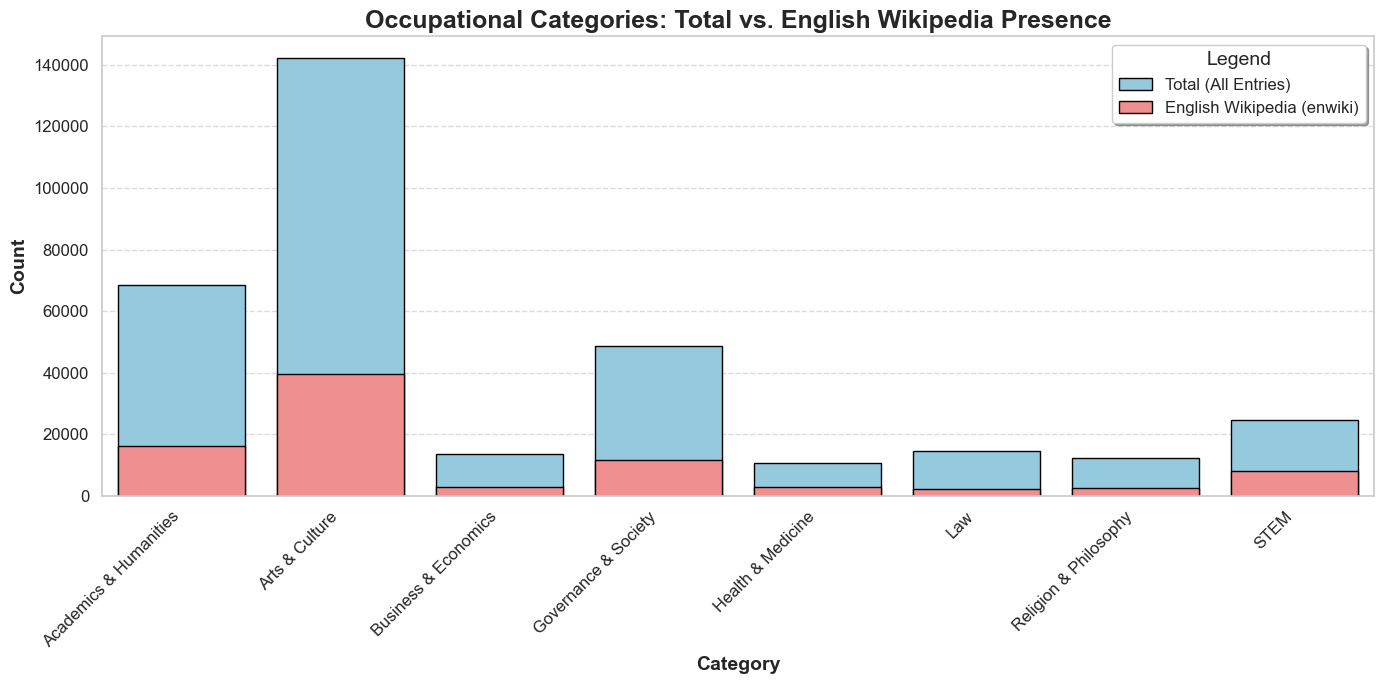

In [ ]:

# Load the pre-processed data
result = pd.read_csv('occupational_category_counts.csv')

# Set Seaborn style
sns.set_theme(style="whitegrid", palette="pastel")

# Create a figure for the plot
plt.figure(figsize=(14, 7))

# Plot total counts as a barplot
sns.barplot(
    x='category',
    y='total_count',
    data=result,
    color='#87CEEB',  # Light blue color
    label='Total (All Entries)',
    edgecolor='black'
)

# Overlay enwiki counts as a barplot
sns.barplot(
    x='category',
    y='enwiki_count',
    data=result,
    color='#FF7F7F',  # Light salmon color
    label='English Wikipedia (enwiki)',
    edgecolor='black'
)

# Customize the plot
plt.title('Occupational Categories: Total vs. English Wikipedia Presence', fontsize=18, fontweight='bold')
plt.xlabel('Category', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, title='Legend', title_fontsize=14, loc='upper right', frameon=True, shadow=True)

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('total_vs_enwiki_categories_pretty.png', dpi=300)

# Display the plot
plt.show()

In [ ]:

merged = pd.read_csv('wiki_with_labels_numeric.csv')
# Add century column
merged['century'] = (merged['birthyear'] // 100) * 100

# Split comma-separated labels and explode into rows
merged['label'] = merged['label'].astype(str).str.split(',')
exploded = merged.explode('label')

# Convert labels to integers and clean
exploded['label'] = pd.to_numeric(exploded['label'], errors='coerce')
exploded = exploded.dropna(subset=['label'])
exploded['label'] = exploded['label'].astype(int)

# Category mapping
category_names = {
    1: "Academics & Humanities",
    2: "Arts & Culture",
    3: "Business & Economics",
    4: "Governance & Society",
    5: "Health & Medicine",
    6: "Law",
    7: "Religion & Philosophy",
    8: "STEM"
}
exploded['category'] = exploded['label'].map(category_names)

# Set style
sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 300

# 2. Plot total occupational categories
print("Plotting total categories...")
plt.figure(figsize=(12, 6))
total_counts = exploded['category'].value_counts().sort_index()
ax = sns.barplot(x=total_counts.index, y=total_counts.values, palette="viridis")
plt.title('Total Occupational Categories (All Centuries)', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add value labels
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.savefig('total_occupational_categories.png')
plt.close()

# 3. Plot trends by century (absolute counts)
print("Plotting trends by century...")
century_counts = exploded.groupby(['century', 'category']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 7))
century_counts.plot(kind='area', stacked=True, alpha=0.7, colormap='viridis')
plt.title('Occupational Categories by Century', fontsize=16)
plt.xlabel('Century', fontsize=12)
plt.ylabel('Number of Entries', fontsize=12)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('occupational_trends_by_century.png')
plt.close()


century_pct = century_counts.div(century_counts.sum(axis=1), axis=0) * 100

plt.figure(figsize=(14, 7))
century_pct.plot(kind='area', stacked=True, alpha=0.7, colormap='viridis')
plt.title('Occupational Categories by Century (% of Total per Century)', fontsize=16)
plt.xlabel('Century', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('occupational_trends_by_century_pct.png')
plt.close()

Loading and preparing data...
Plotting total categories...


C:\Users\lemon\AppData\Local\Temp\ipykernel_15868\176486980.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=total_counts.index, y=total_counts.values, palette="viridis")


Plotting trends by century...
Plotting normalized trends...
All plots saved successfully!


<Figure size 4200x2100 with 0 Axes>

<Figure size 4200x2100 with 0 Axes>

Processing geodata

In [188]:
filtered_data = data[data['enwiki'] != 'No']

# Sum up the views for German and English Wikipedia
german_views = filtered_data['de_views'].sum()
english_views = filtered_data['en_views'].sum()

# Compare the views
if german_views > english_views:
    print(f"German Wikipedia has more views for shared pages: {german_views} vs {english_views}")
else:
    print(f"English Wikipedia has more views for shared pages: {english_views} vs {german_views}")

German Wikipedia has more views for shared pages: 6677226848 vs 4000514521


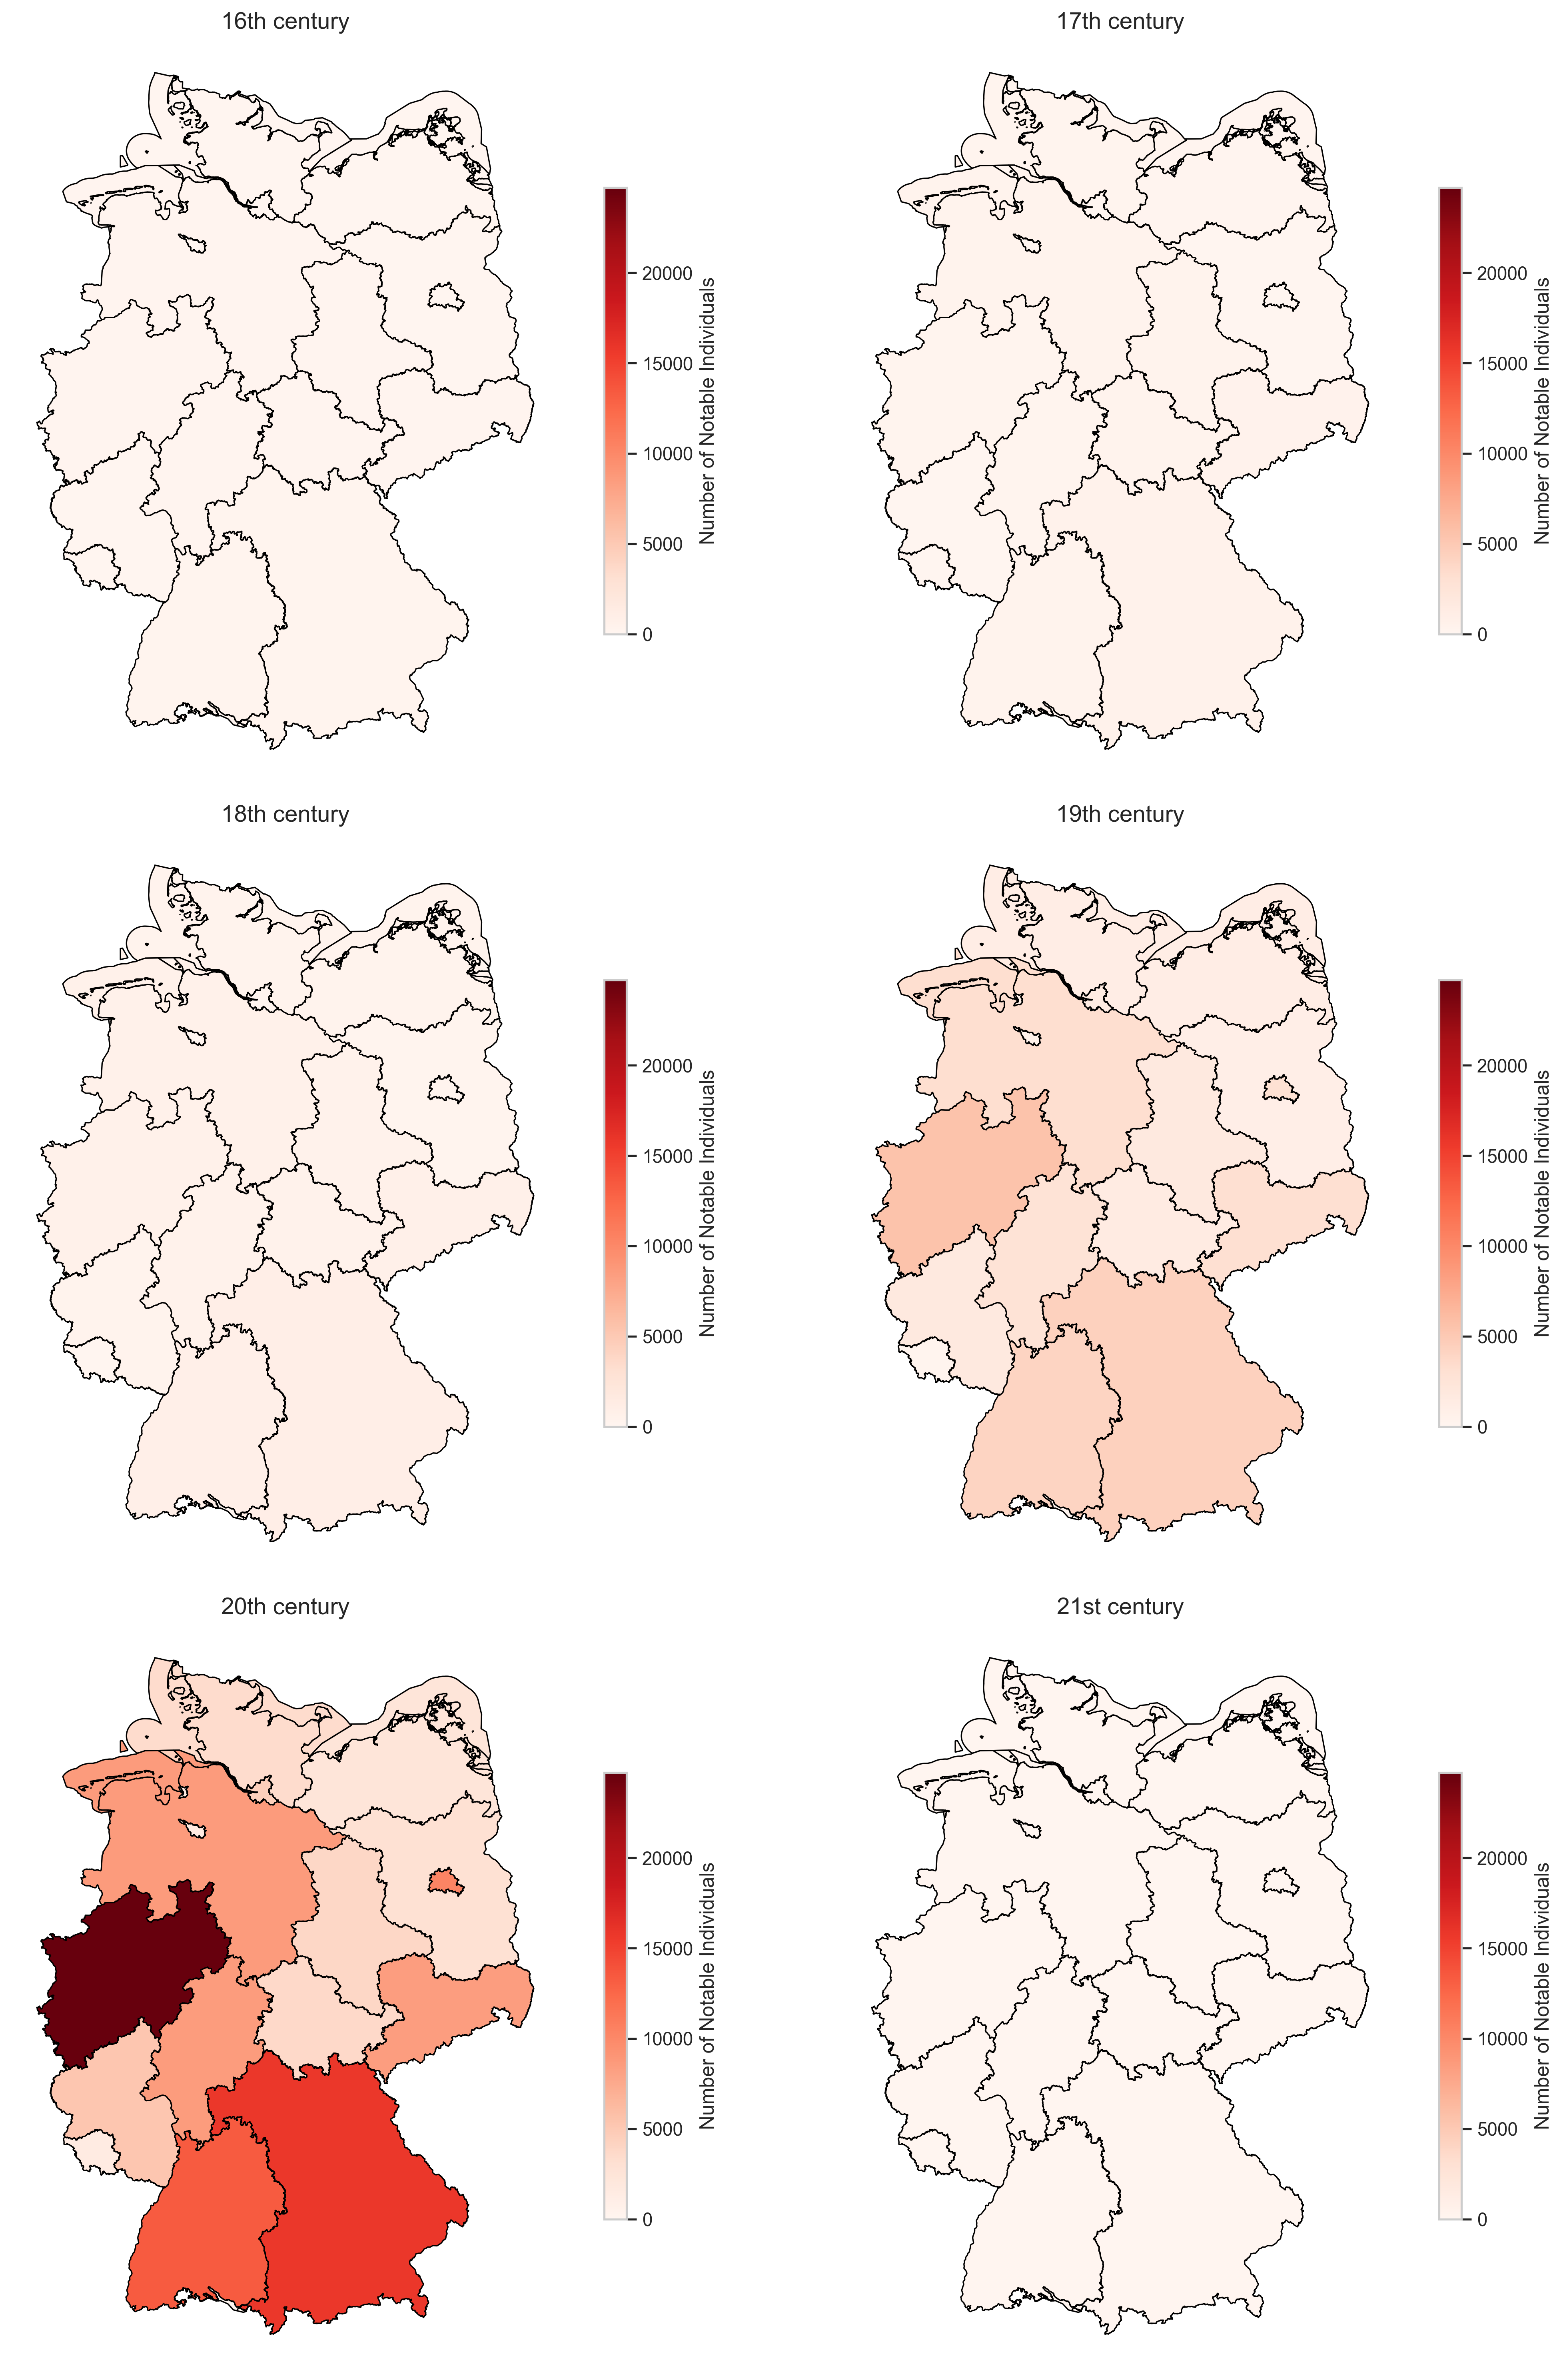

In [ ]:
# Load your data
data = pd.read_csv('wiki_dataset.csv')  # Replace with your actual file

# Load German administrative boundaries (Bundesländer)
germany_states = gpd.read_file('bundeslaender_simplify0.geojson')  # Replace with actual path

# Data Cleaning Function
def parse_dates(date_str):
    try:
        return datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
    except:
        return datetime.strptime(date_str.split('T')[0], '%Y-%m-%d')

# Extract coordinates safely
data[['longitude', 'latitude']] = data['birthplace_coords'].str.extract(
    r'Point\(([-\d.]+)\s+([-\d.]+)\)').astype(float)

# Drop rows with missing coordinates
data.dropna(subset=['longitude', 'latitude'], inplace=True)

# Create century column
data['century'] = data['birthyear'].apply(lambda x: f"{(x // 100) + 1}th century")

# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(data['longitude'], data['latitude'])]
gdf = gpd.GeoDataFrame(data, geometry=geometry, crs="EPSG:4326")

# Filter for Germany using the bounding box of the shapefile
germany_bbox = germany_states.total_bounds
gdf = gdf.cx[germany_bbox[0]:germany_bbox[2], germany_bbox[1]:germany_bbox[3]]

# Filter for centuries of interest
centuries_of_interest = ['16th century', '17th century', '18th century', '19th century', '20th century', '21st century']
gdf = gdf[gdf['century'].isin(centuries_of_interest)]

# Spatial join with German states
gdf = gpd.sjoin(gdf, germany_states, how='inner', predicate='intersects')

# Group by state and century, and count individuals
state_counts = gdf.groupby(['name', 'century']).size().reset_index(name='count')

# Merge counts with the Germany states GeoDataFrame for each century
century_maps = []
for century in centuries_of_interest:
    century_data = state_counts[state_counts['century'] == century][['name', 'count']]
    germany_states_century = germany_states.merge(century_data, on='name', how='left')
    germany_states_century['count'] = germany_states_century['count'].fillna(0)
    century_maps.append(germany_states_century)

# Determine the global maximum count for consistent color scaling
max_count = max([df['count'].max() for df in century_maps])

# Plot all maps in a 3x2 grid
fig, axes = plt.subplots(3, 2, figsize=(15, 20))
axes = axes.flatten()

for i, century in enumerate(centuries_of_interest):
    ax = axes[i]
    germany_states_century = century_maps[i]
    germany_states_century.plot(
        column='count',
        cmap='Reds',
        linewidth=0.8,
        edgecolor='black',
        legend=True,
        legend_kwds={'label': "Number of Notable Individuals", 'shrink': 0.6},
        vmin=0,
        vmax=max_count,
        ax=ax
    )
    ax.set_title(f"{century}", fontsize=14)
    ax.axis('off')

# Remove empty subplots if any
for j in range(len(centuries_of_interest), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


In [204]:
print(germany_states)

                            name  cartodb_id                       created_at  \
0             Schleswig-Holstein           1 2025-03-22 09:28:43.893000+00:00   
1                        Hamburg           2 2025-03-22 09:28:43.893000+00:00   
2                  Niedersachsen           3 2025-03-22 09:28:43.893000+00:00   
3                         Bremen           4 2025-03-22 09:28:43.893000+00:00   
4            Nordrhein-Westfalen           5 2025-03-22 09:28:43.893000+00:00   
5                         Hessen           6 2025-03-22 09:28:43.893000+00:00   
6                Rheinland-Pfalz           7 2025-03-22 09:28:43.893000+00:00   
7              Baden-Württemberg           8 2025-03-22 09:28:43.893000+00:00   
8                         Bayern           9 2025-03-22 09:28:43.893000+00:00   
9                       Saarland          10 2025-03-22 09:28:43.893000+00:00   
10                        Berlin          11 2025-03-22 09:28:43.893000+00:00   
11                   Branden